In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.under_sampling import NeighbourhoodCleaningRule
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.metrics import classification_report, recall_score, precision_score,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/copy_BRFSS_reduced_v3.csv')

In [3]:
X = df.drop('Heart_disease', axis=1)
y = df['Heart_disease']

In [ ]:
y.value_counts()

0    212379
1     19261
Name: Heart_disease, dtype: int64

In [4]:
X_brfss, _, y_brfss, _ = train_test_split(X, y, train_size=0.5, stratify=y, random_state=42)

In [6]:
y_brfss.value_counts()

0    21238
1     1926
Name: Heart_disease, dtype: int64

In [11]:
from sklearn.metrics import silhouette_score

# Define ranges for hyperparameters
eps_values = [3.0,5.0,10.0, 20.0, 30.0]
min_samples_values = np.arange(1, 30, 3)

best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_resampled)

        # Calculate the number of clusters and noise points
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        if n_clusters > 1:
            score = silhouette_score(X_resampled, cluster_labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best EPS: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_score}")

Best EPS: 30.0
Best min_samples: 19
Best Silhouette Score: 0.5340663826588165


In [5]:
def resample_brfss(X_train, y_train):

    smote_nc = SMOTENC(sampling_strategy='auto', categorical_features=np.arange(0,12))
    X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(X_resampled)
    cluster_labels = dbscan.labels_

    synthetic_samples = X_resampled[cluster_labels != -1]
    real_samples = X_resampled[cluster_labels == -1]
    synthetic_indices = np.where(cluster_labels != -1)
    real_indices = np.where(cluster_labels == -1)

    y_resampled_synthetic = y_resampled.iloc[synthetic_indices]
    y_resampled_real = y_resampled.iloc[real_indices]

    # Perform KNN thresholding for noise removal
    nn_synthetic = NearestNeighbors(n_neighbors=5)
    nn_synthetic.fit(synthetic_samples)
    distances, _ = nn_synthetic.kneighbors(synthetic_samples)

    distance_threshold = np.mean(distances)

    final_synthetic_indices = np.where(np.mean(distances, axis=1) < distance_threshold)
    final_synthetic_samples = synthetic_samples.iloc[final_synthetic_indices]
    final_synthetic_labels = y_resampled_synthetic.iloc[final_synthetic_indices]

    # Step 4: Noise Removal and Final Dataset Generation
    resampled_X_train = np.vstack((final_synthetic_samples, real_samples))
    resampled_y_train = np.concatenate((final_synthetic_labels, y_resampled_real))

    return resampled_X_train, resampled_y_train

In [10]:
# def evaluate_classifiers_brfss1(classifiers, X, y):
#     for clf_name, clf in classifiers.items():
#         train_scores = []
#         test_scores = []

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#         X_train_processed, y_train_processed = resample_brfss(X_train, y_train)

#         clf.fit(X_train_processed, y_train_processed)

#         train_preds = clf.predict(X_train_processed)
#         test_preds = clf.predict(X_test)

#         train_score = f1_score(y_train_processed, train_preds)
#         test_score = f1_score(y_test, test_preds)

#         train_scores.append(train_score)
#         test_scores.append(test_score)

#         # Calculate and print scores for the classifier
#         avg_train_score = np.mean(train_scores)
#         avg_test_score = np.mean(test_scores)
#         print(f"{clf_name}:")
#         print(f"  Train F1-Score: {avg_train_score:.2f}")
#         print(f"  Test F1-Score: {avg_test_score:.2f}")

#         # Plot learning curve
#         plt.figure()
#         plt.title(f"Learning Curve - {clf_name}")
#         plt.xlabel("Training examples")
#         plt.ylabel("F1-Score")
#         plt.grid()

#         train_sizes = np.linspace(0.1, 1.0, 10)
#         plt.ylim(0.0, 1.1)
#         plt.plot(train_sizes, train_scores * len(X_train) / len(X), 'o-', color="r", label="Training F1-Score")
#         plt.plot(train_sizes, test_scores, 'o-', color="g", label="Test F1-Score")

#         plt.legend(loc="best")
#         plt.show()

In [ ]:
# brfss_classifiers_lr = {"Logistic Regression": LogisticRegression(max_iter=1000,random_state=42)}

# evaluate_classifiers_brfss1(brfss_classifiers_lr, X_brfss, y_brfss)

In [6]:
skf_brfss = StratifiedKFold(n_splits=5, shuffle=False)

def evaluate_classifier_brfss(clf, X, y):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f1_scores = []
    precisions = []
    recalls = []

    for train_idx, test_idx in skf_brfss.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        sc = StandardScaler()
        sc.fit(X_train)

        x_train_scaled = sc.transform(X_train)
        x_test_scaled = sc.transform(X_test)

        X_train_resampled, y_train_resampled = resample_brfss(x_train_scaled, y_train)

        clf.fit(X_train_resampled, y_train_resampled)
        y_pred = clf.predict(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0

        aucs.append(auc(fpr, tpr))
        f1_scores.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))

    metrics = {
        "Average AUROC": np.mean(aucs),
        "Average F1 scores": np.mean(f1_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }

    return metrics

In [7]:
def plot_learning_curve_comparison_brfss(classifiers, X, y, cv):
    plt.figure(figsize=(8, 4))

    for clf in classifiers:
        train_sizes, train_scores, test_scores = [], [], []

        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_train_resampled, y_train_resampled = resample_brfss(X_train, y_train)

            sizes, train_score, test_score = learning_curve(clf, X_train_resampled, y_train_resampled,
                                                            cv=cv, n_jobs=-1, scoring='f1',
                                                            train_sizes=np.linspace(0.1, 1.0, 10))


            train_sizes.append(sizes)
            train_scores.append(np.mean(train_score, axis=1))
            test_scores.append(np.mean(test_score, axis=1))

        avg_train_scores = np.mean(train_scores, axis=0)
        avg_test_scores = np.mean(test_scores, axis=0)

        clf_name = type(clf).__name__
        plt.plot(train_sizes[0], avg_test_scores, '--', label=clf_name)

    plt.title('Learning Curves Comparison on ASSKT BRFSS 2021 cleveland Data')
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='best')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
asskt_brfss_lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
evaluate_classifier_brfss(asskt_brfss_lr, X_brfss,y_brfss)

In [ ]:
asskt_brfss_lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, C=1, penalty='l1', solver='liblinear')
evaluate_classifier_brfss(asskt_brfss_lr, x_brfss_scaled,y_brfss)

{'Average AUROC': 0.7532884714323487,
 'Average F1 scores': 0.32624718875997194,
 'Precision': 0.20641709059562324,
 'Recall': 0.7778008957261974}

In [ ]:
asskt_brfss_lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
evaluate_classifier_brfss(asskt_brfss_lr, X,y)

{'Average AUROC': 0.75360603743819,
 'Average F1 scores': 0.32680801621743033,
 'Precision': 0.2069230338103003,
 'Recall': 0.778204112623747}

In [ ]:
asskt_brfss_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
evaluate_classifier_brfss(asskt_brfss_rf, X_brfss, y_brfss)

In [ ]:
asskt_brfss_nb = GaussianNB()
evaluate_classifier_brfss(asskt_brfss_nb, X_brfss, y_brfss)

In [ ]:
asskt_brfss_xgb = xgb.XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3, random_state=42)
evaluate_classifier_brfss(asskt_brfss_xgb, X_brfss, y_brfss)

In [ ]:
classifiers_brfss = [asskt_brfss_lr, asskt_brfss_rf, asskt_brfss_nb,
                     asskt_brfss_xgb]

plot_learning_curve_comparison_cleveland(X)

Logistic Regression:
  Average Train F1-Score: 0.71
  Average Test F1-Score: 0.35
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     21237
           1       0.22      0.70      0.34      1927

    accuracy                           0.77     23164
   macro avg       0.59      0.74      0.60     23164
weighted avg       0.90      0.77      0.82     23164



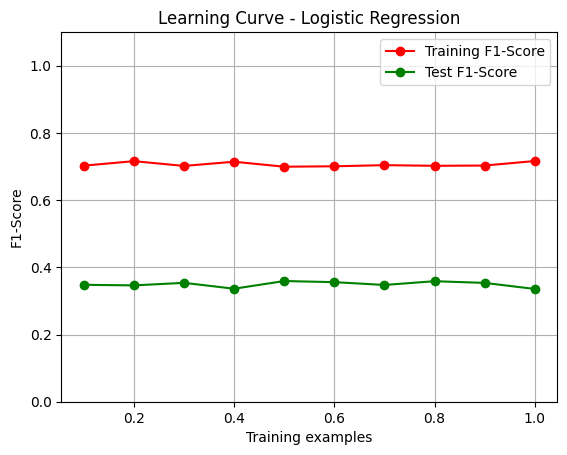

In [ ]:
classifiers = {"Logistic Regression": LogisticRegression(max_iter=2000)}

evaluate_classifiers(classifiers, X, y)

Logistic Regression:
  Average Train F1-Score: 0.77
  Average Test F1-Score: 0.33
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     21237
           1       0.20      0.79      0.32      1927

    accuracy                           0.72     23164
   macro avg       0.59      0.75      0.57     23164
weighted avg       0.91      0.72      0.78     23164



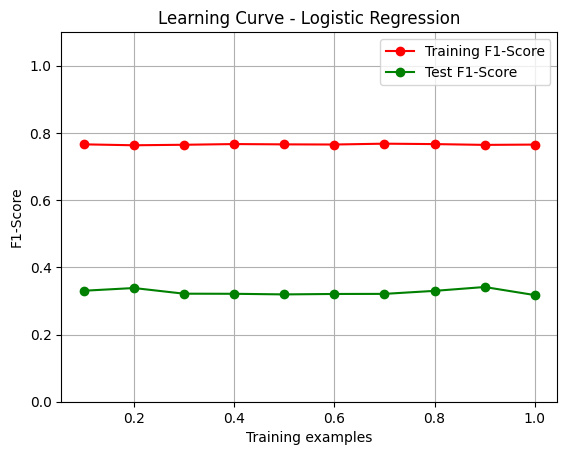

In [ ]:
classifier_lr = {"Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1)}

evaluate_classifiers(classifier_lr, X, y)

Naive Bayes:
  Average Train F1-Score: 0.67
  Average Test F1-Score: 0.34
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     21237
           1       0.23      0.63      0.34      1927

    accuracy                           0.80     23164
   macro avg       0.60      0.72      0.61     23164
weighted avg       0.90      0.80      0.84     23164



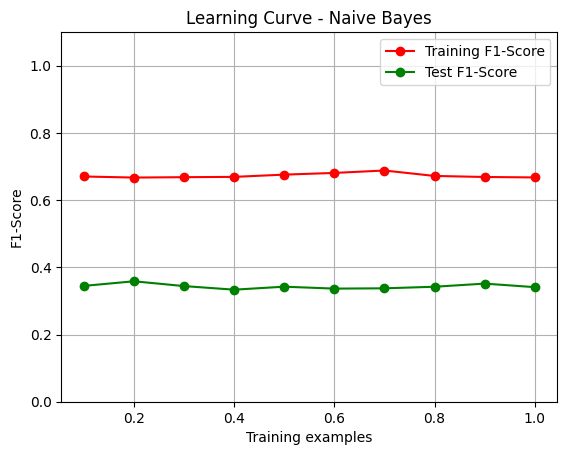

In [ ]:
from sklearn.naive_bayes import GaussianNB

classifier_nb = {"Naive Bayes": GaussianNB()}

evaluate_classifiers(classifier_nb, X, y)

Random Forest:
  Average Train F1-Score: 0.99
  Average Test F1-Score: 0.28
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     21237
           1       0.27      0.31      0.29      1927

    accuracy                           0.87     23164
   macro avg       0.60      0.62      0.61     23164
weighted avg       0.88      0.87      0.88     23164



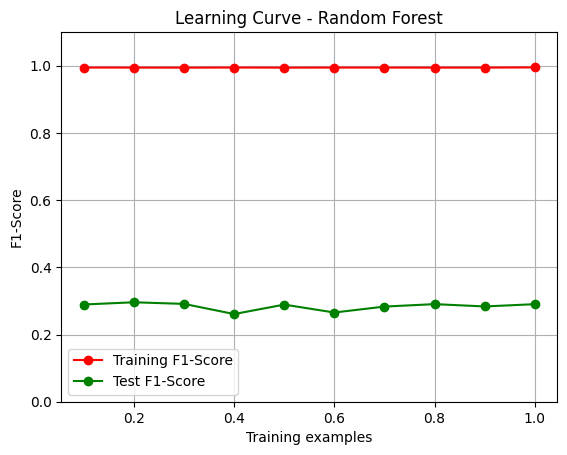

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = {"Random Forest": RandomForestClassifier(random_state=42)}

plot_learning_curve_comparison_cleveland(classifiers_asskt, X_cleveland, y_cleveland, skf)

ASSKT- UCI Cleveland Dataset

In [2]:
df1 = pd.read_csv('/content/drive/MyDrive/cleveland_heartdis_v1.csv')
df1.drop('Unnamed: 0',axis=1, inplace=True)

In [3]:
X_cleveland = df1.drop('Heart_disease', axis=1)
y_cleveland = df1['Heart_disease']

In [31]:
# 1. SMOTE-NC Resampling
smote_nc = SMOTENC(sampling_strategy='auto', categorical_features=np.arange(0,12))
X_resampled, y_resampled = smote_nc.fit_resample(X_cleveland, y_cleveland)

# 2. DBSCAN Clustering
dbscan = DBSCAN(eps=30, min_samples=4)
dbscan.fit(X_resampled)
cluster_labels = dbscan.labels_

# Remove Noisy Samples using DBSCAN
synthetic_indices = np.where(cluster_labels != -1)
X_synthetic = X_resampled.iloc[synthetic_indices]
y_synthetic = y_resampled.iloc[synthetic_indices]

# 3. KNN Thresholding for Noise Removal
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_synthetic)
distances, _ = nn.kneighbors(X_synthetic)
distance_threshold = np.mean(distances)
selected_indices = np.where(np.mean(distances, axis=1) < distance_threshold)

refined_X = X_synthetic.iloc[selected_indices]
refined_y = y_synthetic.iloc[selected_indices]

# 4. Final Dataset Generation
resampled_X_train = refined_X.values  # Convert DataFrame to numpy array for consistency
resampled_y_train = refined_y.values

# Ensure shapes match
assert resampled_X_train.shape[0] == resampled_y_train.shape[0], "Shapes of resampled_X_train and resampled_y_train do not match!"


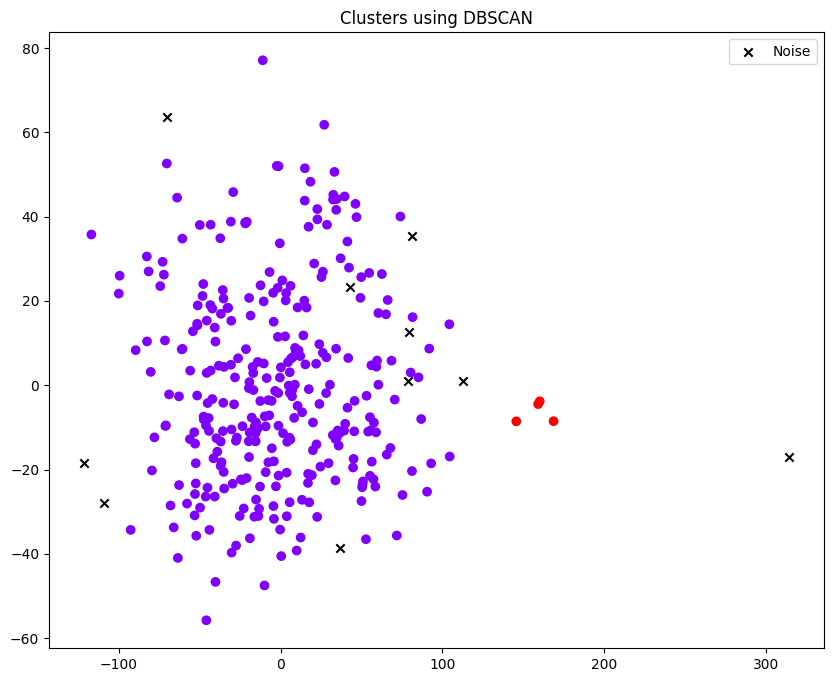

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[cluster_labels == -1, 0], X_pca[cluster_labels == -1, 1], c='black', marker='x', label='Noise')
plt.scatter(X_pca[cluster_labels != -1, 0], X_pca[cluster_labels != -1, 1], c=cluster_labels[cluster_labels != -1], cmap='rainbow')
plt.title('Clusters using DBSCAN')
plt.legend()
plt.show()

In [55]:
def asskt_cleveland(X_train, y_train):

    smote_nc = SMOTENC(sampling_strategy='auto', categorical_features=[1,2,5,6,8,10,11,12,13,14,15])
    X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

    dbscan = DBSCAN(eps=30, min_samples=15)
    dbscan.fit(X_resampled)
    cluster_labels = dbscan.labels_

    synthetic_samples = X_resampled[cluster_labels != -1]
    real_samples = X_resampled[cluster_labels == -1]
    synthetic_indices = np.where(cluster_labels != -1)
    real_indices = np.where(cluster_labels == -1)

    y_resampled_synthetic = y_resampled.iloc[synthetic_indices]
    y_resampled_real = y_resampled.iloc[real_indices]

    # Perform KNN thresholding for noise removal
    nn_synthetic = NearestNeighbors(n_neighbors=3)
    nn_synthetic.fit(synthetic_samples)
    distances, _ = nn_synthetic.kneighbors(synthetic_samples)

    distance_threshold = np.mean(distances)

    final_synthetic_indices = np.where(np.mean(distances, axis=1) < distance_threshold)
    final_synthetic_samples = synthetic_samples.iloc[final_synthetic_indices]
    final_synthetic_labels = y_resampled_synthetic.iloc[final_synthetic_indices]

    # Step 4: Noise Removal and Final Dataset Generation
    resampled_X_train = np.vstack((final_synthetic_samples, real_samples))
    resampled_y_train = np.concatenate((final_synthetic_labels, y_resampled_real))

    return resampled_X_train, resampled_y_train

In [56]:
skf = StratifiedKFold(n_splits=5, shuffle=False)

def evaluate_classifier_cleveland(clf, X, y):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f1_scores = []
    precisions = []
    recalls = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        X_train_resampled, y_train_resampled = asskt_cleveland(X_train, y_train)

        clf.fit(X_train_resampled, y_train_resampled)
        y_pred = clf.predict(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0

        aucs.append(auc(fpr, tpr))
        f1_scores.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))

    metrics = {
        "Average AUROC": np.mean(aucs),
        "Average F1 scores": np.mean(f1_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }

    return metrics

In [53]:
def plot_learning_curve_comparison_cleveland(classifiers, X, y, cv):
    plt.figure(figsize=(8, 4))

    for clf in classifiers:
        train_sizes, train_scores, test_scores = [], [], []

        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_train_resampled, y_train_resampled = asskt_cleveland(X_train, y_train)

            sizes, train_score, test_score = learning_curve(clf, X_train_resampled, y_train_resampled,
                                                            cv=cv, n_jobs=-1, scoring='f1',
                                                            train_sizes=np.linspace(0.1, 1.0, 10))


            train_sizes.append(sizes)
            train_scores.append(np.mean(train_score, axis=1))
            test_scores.append(np.mean(test_score, axis=1))

        avg_train_scores = np.mean(train_scores, axis=0)
        avg_test_scores = np.mean(test_scores, axis=0)

        clf_name = type(clf).__name__
        plt.plot(train_sizes[0], avg_test_scores, '--', label=clf_name)

    plt.title('Learning Curves Comparison on ASSKT UCI cleveland Data')
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='best')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [59]:
asskt_cleveland_lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
evaluate_classifier_cleveland(asskt_cleveland_lr, X_cleveland,y_cleveland)

{'Average AUROC': 0.8205741167434717,
 'Average F1 scores': 0.8078103536682614,
 'Precision': 0.8000970501068648,
 'Recall': 0.8238095238095238}

In [64]:
asskt_cleveland_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
evaluate_classifier_cleveland(asskt_cleveland_rf, X_cleveland, y_cleveland)

{'Average AUROC': 0.8006368407578085,
 'Average F1 scores': 0.7866488593627434,
 'Precision': 0.7817857142857143,
 'Recall': 0.7960317460317461}

In [65]:
asskt_cleveland_nb = GaussianNB()
evaluate_classifier_cleveland(asskt_cleveland_nb, X_cleveland, y_cleveland)

{'Average AUROC': 0.8165445255162996,
 'Average F1 scores': 0.8026223601695299,
 'Precision': 0.8036756347101175,
 'Recall': 0.8026455026455027}

In [71]:
asskt_cleveland_xgb = xgb.XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3, random_state=42)
evaluate_classifier_cleveland(asskt_cleveland_xgb, X_cleveland, y_cleveland)

{'Average AUROC': 0.7927318015019628,
 'Average F1 scores': 0.7771393241658672,
 'Precision': 0.7806838565828749,
 'Recall': 0.7804232804232804}

In [79]:
asskt_cleveland_mlp = MLPClassifier(max_iter=2000, random_state=42)

evaluate_classifier_cleveland(asskt_cleveland_mlp, X_cleveland, y_cleveland)

{'Average AUROC': 0.45894670592251235,
 'Average F1 scores': 0.5904876750789694,
 'Precision': 0.44016909172232677,
 'Recall': 0.898941798941799}

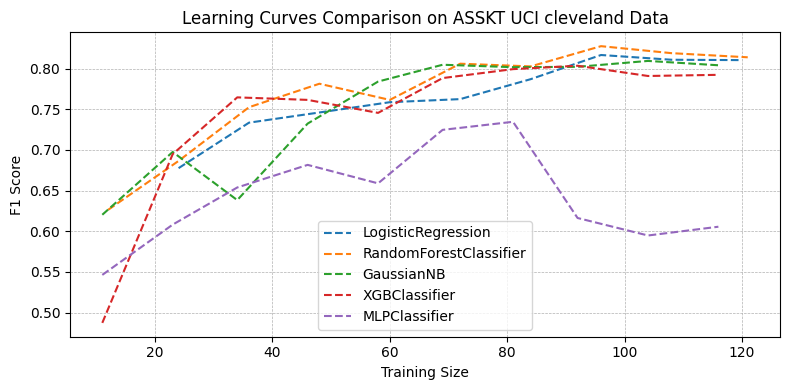

In [80]:
classifiers_asskt = [asskt_cleveland_lr, asskt_cleveland_rf, asskt_cleveland_nb,
               asskt_cleveland_xgb, asskt_cleveland_mlp]

plot_learning_curve_comparison_cleveland(classifiers_asskt, X_cleveland, y_cleveland, skf)

Further Optimization of the Logstic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def tune_logistic_regression(X, y):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': [1000,2000,3000]
    }

    clf = LogisticRegression(max_iter=1000)

    grid_clf = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
    metrics = evaluate_classifier_cleveland(grid_clf, X, y)

    return grid_clf, metrics

def plot_grid_search_results(grid_clf):
    results = pd.DataFrame(grid_clf.cv_results_)
    scores = results[['param_C', 'param_penalty', 'mean_test_score']]

    l1_scores = scores[scores['param_penalty'] == 'l1']
    l2_scores = scores[scores['param_penalty'] == 'l2']

    plt.figure(figsize=(8, 4))

    plt.plot(l1_scores['param_C'], l1_scores['mean_test_score'], marker='o', label='L1 Penalty')
    plt.plot(l2_scores['param_C'], l2_scores['mean_test_score'], marker='x', label='L2 Penalty')
    plt.xscale('log')
    plt.xlabel('Regularization Strength (C)')
    plt.ylabel('Mean ROC AUC Score')
    plt.legend()
    plt.title('Grid Search Results for Logistic Regression')
    plt.show()

In [ ]:
grid_clf, metrics = tune_logistic_regression(X_cleveland, y_cleveland)

print("Best Parameters:", grid_clf.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


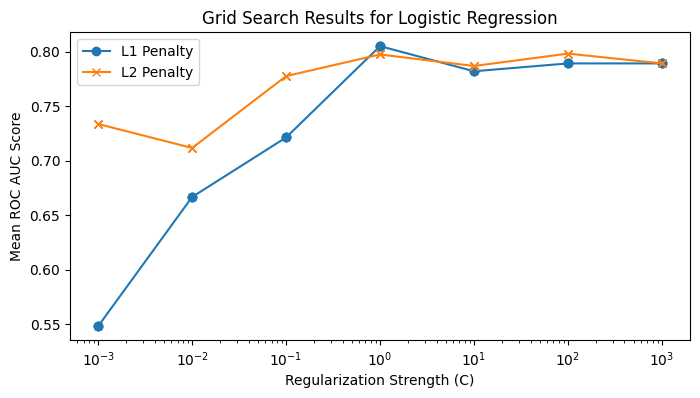

In [ ]:
plot_grid_search_results(grid_clf)

In [ ]:
asskt_cleveland_lr = LogisticRegression(max_iter=2000, C=1, penalty='l1', solver='liblinear', random_state=42, n_jobs=-1)
evaluate_classifier_cleveland(asskt_cleveland_lr, X_cleveland,y_cleveland)

{'Average AUROC': 0.8001194743130228,
 'Average F1 scores': 0.7864868689343669,
 'Precision': 0.7806726088149893,
 'Recall': 0.8018518518518519}